<img src="images/brain.jpeg" width="500"/>

# Stroke Prediciton Analysis
Author: Volha Puzikava
***

## Overview
Every 40 seconds, someone in the United States has a stroke. Every 3.5 minutes, someone dies of stroke. Every year, more than 795,000 people in the United States have a stroke. According to the World Health Organization (WHO), stroke is the 2nd leading cause of death globally, responsible for approximately 11% of total deaths. Moreover, stroke is a leading cause of serious long-term disability.

This project tends to predict whether a patient is more likely to get a stroke during their lifetime and thus, helps to reduce stroke occurence and prevent the illness before it happens. 
***

## Business Problem
The World Health Organization asked to analyze the stroke dataset and provide information about what parameters likely increase the occurence of stroke in people, so the people with the higher chance of getting stroke can be monitored more often in order to prevent the illness before it strikes. The main purpose of the analysis was to build different machine learning algorithms and choose the one that has the highest performance rate predicting the stroke occurence.
***

## Data Understanding
The data for the analysis was taken from [kaggle website](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset?select=healthcare-dataset-stroke-data.csv). The data provided 11 clinical features for predicting stroke effect: gender and age of the patients, their marital status, work type, residence type, smoking status, the precense of hypertension and heart disease, average glucose level and body mass index. The dataset contained information about 5,110 patients.
***

In [1]:
# Load the dataset and inspect the head to make sure everything loaded correctly
import pandas as pd
df = pd.read_csv('Data/Stroke.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


***

## Data Preparation and Exploration
The first step was to check how imbalanced the dataset was. Since the column "stroke" served as the indicator of weather or not a patient had a stroke, the distribution of values in that column was calculated. It turned out that the dataset was imbalanced: 95% of people did not have a stroke, while only 5% had. 

The dataset was then checked for the presence of missing values. They were present only in "bmi" column and were replaced with the column's mean value.

In [2]:
# Check the data type of each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [3]:
# Check for class imbalance
print("Raw Counts:")
print(df['stroke'].value_counts())
print()
print('Percentages:')
print(df['stroke'].value_counts(normalize=True))

Raw Counts:
0    4861
1     249
Name: stroke, dtype: int64

Percentages:
0    0.951272
1    0.048728
Name: stroke, dtype: float64


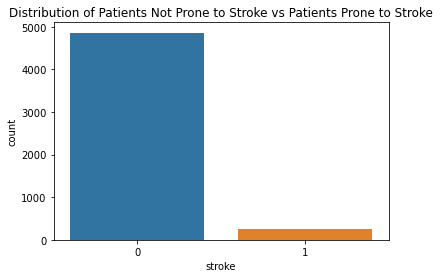

In [4]:
# Plot the distribution of values in column 'stroke'
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

sns.countplot(df['stroke'])
plt.title('Distribution of Patients Not Prone to Stroke vs Patients Prone to Stroke');

As seen from the plot above, the number of people who are prone to stroke is much smaller than the number of people who are not prone to this illness.

In [6]:
# Check for missing values in the dataset
df.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [7]:
# Fill in the missing values in 'bmi' column with mean value
df['bmi'] = df['bmi'].fillna(df.bmi.mean())
df['bmi'] = df['bmi'].round(decimals=1)
df.isna().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

The distribution of stroke occurence was then checked among the numerical features of the dataset. It was found out that the average age of people with stroke is around 67 years, those people are more likely to have hypertension and heart disease and their glucose level is much higher than in people without a stroke. Also, body mass index turned out to be not of a much influence. The pairplot was then used to visualize the relationship betweeen the variables.

In [8]:
# Look at the distibution of stroke among numerical features
df.groupby('stroke').mean()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi
stroke,,,,,,
0,36487.236371,41.971545,0.088871,0.047110,104.795513,28.825612
1,37115.068273,67.728193,0.265060,0.188755,132.544739,30.218876


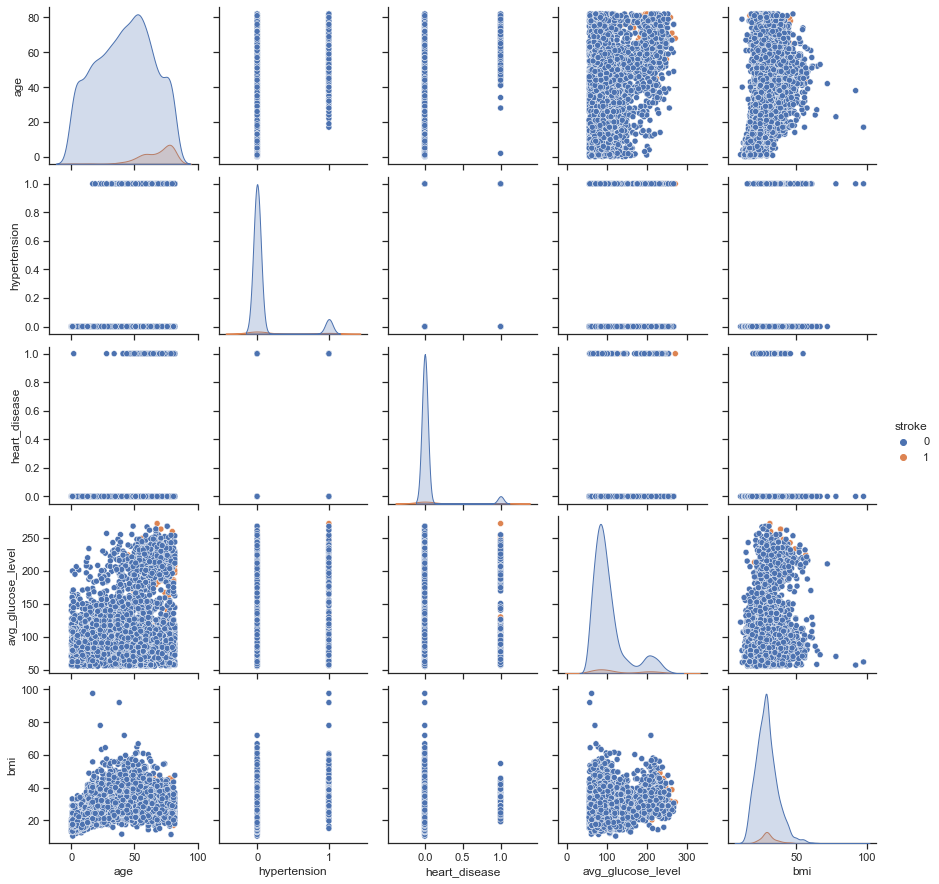

In [10]:
# Distribution of stroke among categorical features
sns.set(style = 'ticks', color_codes=True)
sns.pairplot(data=df, hue='stroke',  
             vars=['age',
                   'hypertension',
                   'heart_disease',
                   'avg_glucose_level',
                   'bmi']);

The stroke incidences were also compared by gender, marital status, work type, residence type and smoking status. It turned out that people who are married, self-employed and formely smokers are more likely to develop stroke in their lifetime. Gender and residence type do not influence much on the occurence of the illness.

Percentage of Stroke Occurence Based on Gender:
gender
Female    4.709419
Male      5.106383
Other     0.000000
Name: stroke, dtype: float64



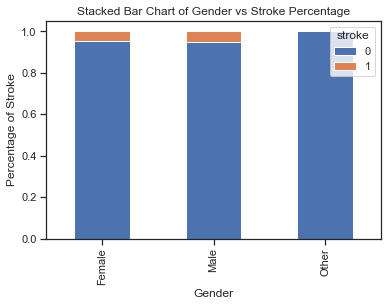

In [11]:
# Distribution of stroke based on gender
print("Percentage of Stroke Occurence Based on Gender:")
print(df.groupby('gender')['stroke'].mean() * 100)
print()
table = pd.crosstab(df.gender, df.stroke)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Gender vs Stroke Percentage')
plt.xlabel('Gender')
plt.ylabel('Percentage of Stroke')
plt.savefig('gender_vs_stroke');

According to the chart above, the percentage of stroke occurence in males and females differs very slightly. Thus, we can state that gender will not play a leading role in stroke incidence prediction.

Percentage of Stroke Occurence Based on Marital Status:
ever_married
No     1.650541
Yes    6.561288
Name: stroke, dtype: float64



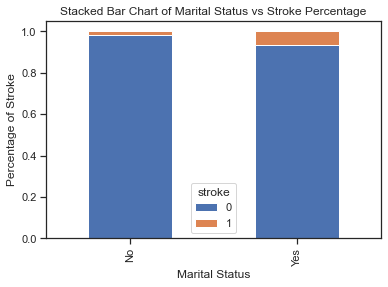

In [12]:
# Distribution of stroke based in marital status
print("Percentage of Stroke Occurence Based on Marital Status:")
print(df.groupby('ever_married')['stroke'].mean() * 100)
print()
table = pd.crosstab(df.ever_married, df.stroke)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Marital Status vs Stroke Percentage')
plt.xlabel('Marital Status')
plt.ylabel('Percentage of Stroke')
plt.savefig('marriage_vs_stroke');

Marital status, on the contrary, influences a lot of the occurence of stroke. As seen on the graph, married people are more likely to develop a stroke in their lifetime.

Percentage of Stroke Occurence Based on Work Type:
work_type
Govt_job         5.022831
Never_worked     0.000000
Private          5.094017
Self-employed    7.936508
children         0.291121
Name: stroke, dtype: float64



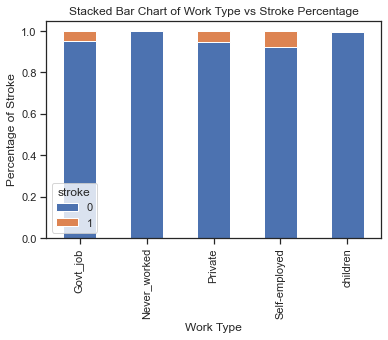

In [13]:
# Distribution of stroke based on work type
print("Percentage of Stroke Occurence Based on Work Type:")
print(df.groupby('work_type')['stroke'].mean() * 100)
print()
table = pd.crosstab(df.work_type, df.stroke)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Work Type vs Stroke Percentage')
plt.xlabel('Work Type')
plt.ylabel('Percentage of Stroke')
plt.savefig('work_vs_stroke');

People who are self-employed, have private or government jobs are more likely to suffer from stroke than people who never worked or are taking care of their children. 

Percentage of Stroke Occurence Based on Residence Type:
Residence_type
Rural    4.534606
Urban    5.200308
Name: stroke, dtype: float64



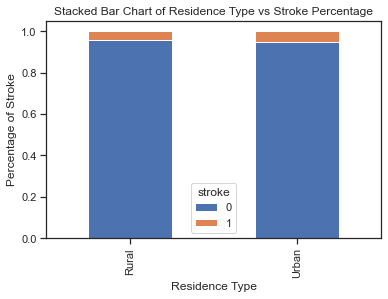

In [14]:
# Distribution of stroke based on residence type
print("Percentage of Stroke Occurence Based on Residence Type:")
print(df.groupby('Residence_type')['stroke'].mean() * 100)
print()
table = pd.crosstab(df.Residence_type, df.stroke)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Residence Type vs Stroke Percentage')
plt.xlabel('Residence Type')
plt.ylabel('Percentage of Stroke')
plt.savefig('residence_vs_stroke');

Residence type has no influence on stroke incidences.

Percentage of Stroke Occurence Based on Smoking Status:
smoking_status
Unknown            3.044041
formerly smoked    7.909605
never smoked       4.756871
smokes             5.323194
Name: stroke, dtype: float64



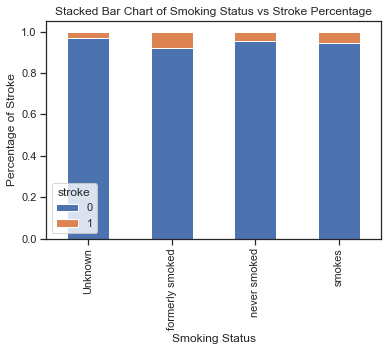

In [15]:
# Distribution of stroke based on smoking status
print("Percentage of Stroke Occurence Based on Smoking Status:")
print(df.groupby('smoking_status')['stroke'].mean() * 100)
print()
table = pd.crosstab(df.smoking_status, df.stroke)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Smoking Status vs Stroke Percentage')
plt.xlabel('Smoking Status')
plt.ylabel('Percentage of Stroke')
plt.savefig('smoking_vs_stroke');

People who smoke or quitted smoking have a higher chance of getting stroke.

In order to be used in a model, all categorical variables ("gender", "ever_married", "Residence_type", "work_type" and "smoking_status") had to be transformed. The first three mentioned columns had the values replaced to numerical ones, while the remaining two columns used dummy variables.

In [16]:
# Transform the categorical variables into numerical 
df['gender'] = df['gender'].replace({'Female': 0, 'Male': 1, 'Other': 2}).astype('int8')
df['ever_married'] = df['ever_married'].replace({'No': 0, 'Yes': 1}).astype('int8')
df['Residence_type'] = df['Residence_type'].replace({'Urban': 0, 'Rural': 1}).astype('int8')

In [17]:
# Create dummy variables
df = pd.get_dummies(df, columns=['work_type', 'smoking_status'])
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,9046,1,67.0,0,1,1,0,228.69,36.6,1,0,0,1,0,0,0,1,0,0
1,51676,0,61.0,0,0,1,1,202.21,28.9,1,0,0,0,1,0,0,0,1,0
2,31112,1,80.0,0,1,1,1,105.92,32.5,1,0,0,1,0,0,0,0,1,0
3,60182,0,49.0,0,0,1,0,171.23,34.4,1,0,0,1,0,0,0,0,0,1
4,1665,0,79.0,1,0,1,1,174.12,24.0,1,0,0,0,1,0,0,0,1,0


It was also important to see if the predictive features would result in multicollinearity in the final model. With that in mind, pearson correlation coefficients of the predictive features were generated and visualized. 

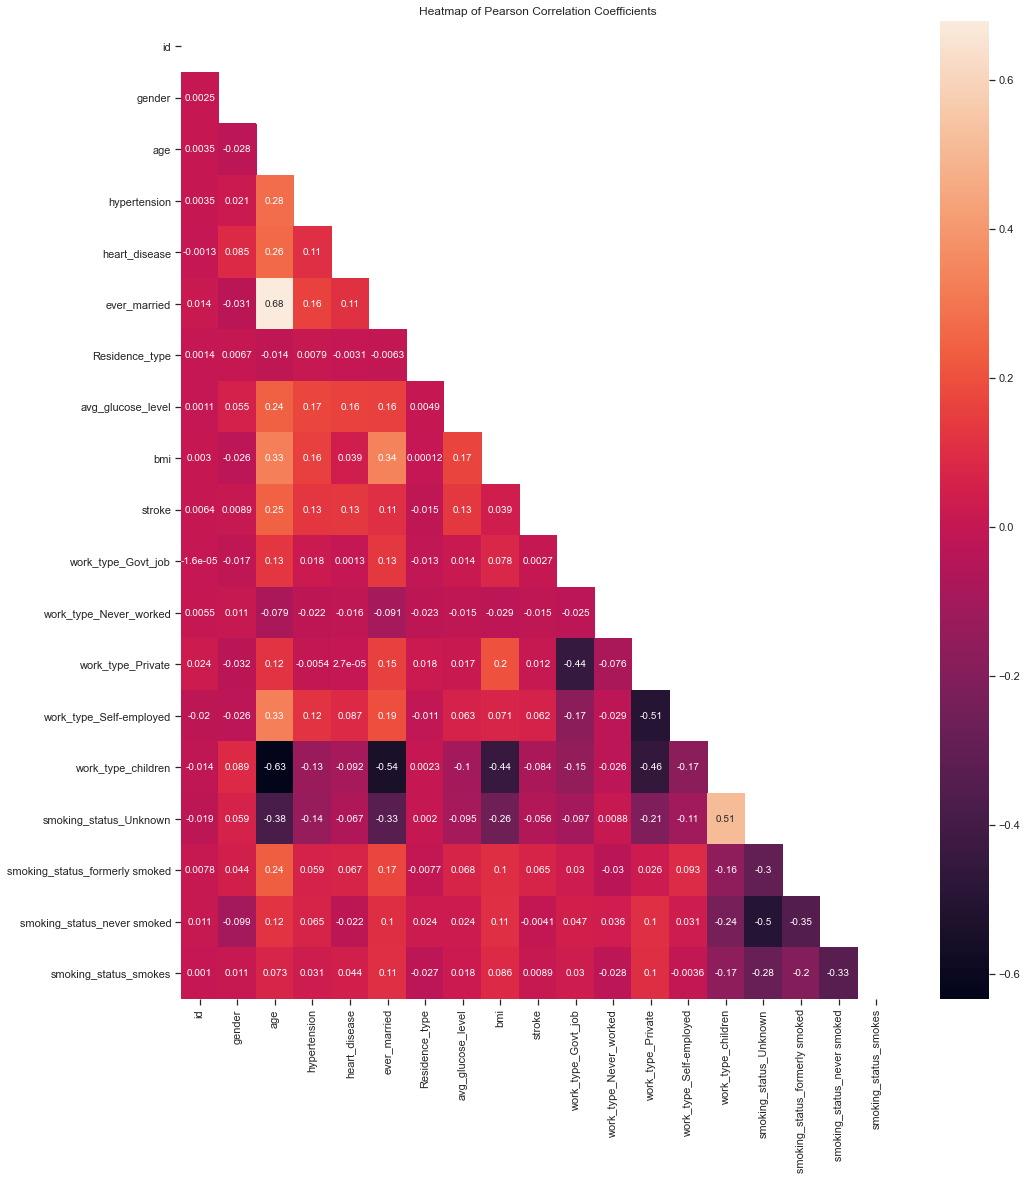

In [18]:
# Visualize the pearson correlation coefficients
import numpy as np

corr = df.corr()
fig, ax = plt.subplots(figsize = (16, 18))
sns.heatmap(data = corr, 
            mask = np.triu(np.ones_like(corr, dtype = bool)), 
            ax = ax, 
            annot = True)
plt.title('Heatmap of Pearson Correlation Coefficients');

According to the heatmap, the highest correlation belonged to "ever_married" and "age" (0.68). The most strongly correlated features with the target variable were "age", "hypertension", "heart_disease", "ever_married" and "avg_glucose_level".

***

## Data Modeling
In order to build any ML model, a train-test split should be performed. The prediction target for this analysis was the column "stroke", so the data was separated into a train set and test set accordingly. The "id" column was dropped since it represented a unique identifier, not an actual numeric feature.

The class imbalance in the training and test set was then found and SMOTE-NC class was used in order to improve the models' performance on the minority class. SMOTE-NC was applied because the dataset contained both categorical and numerical features.

In [19]:
# Split the outcome and predictor variables
y = df['stroke']
X = df.drop(columns=['id', 'stroke'], axis=1)

In [20]:
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)
print(y_train.value_counts(),'\n\n', y_test.value_counts())

0    3645
1     187
Name: stroke, dtype: int64 

 0    1216
1      62
Name: stroke, dtype: int64


In [21]:
# Use SMOTENC class to improve the model's performance on the minority class
from imblearn.over_sampling import SMOTENC

smote = SMOTENC(random_state=42, categorical_features=[1, 5, 6, 7, 10])

# Preview the synthetic sample class distribution
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print(y_train_resampled.value_counts())

1    3645
0    3645
Name: stroke, dtype: int64


Since the World Health Organization really cares about avoiding 'false negatives' more than avoiding 'false positives' (it is a crime to say that a person will not have a stroke, and then he/she will develop it, than predict that the person will have a stroke and he/she will not actually have it), higher recall score and lower number of false negatives will be the metrics the ML models will be evaluated upon. The model with the highest recall will be chosen for the prediction.

Different machine learning algorithms will be build in the following way:

- the baseline model will be build and evaluated;
- one or more hyperparameters will be tuned to find if the model will perform any better;
- the optimized model will be run and checked for any improvements in the performance;
- the model with the highest recall score for each algorithm type will be chosen for further analysis.

#### Logistic Regression Models

In [22]:
# Build a baseline model
from sklearn.linear_model import LogisticRegression

logreg_baseline = LogisticRegression(random_state=42)
logreg_baseline.fit(X_train_resampled, y_train_resampled)

LogisticRegression(random_state=42)

In [23]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

# Write the function that evaluates models on test sets
def print_metrics(labels, preds):
    print("Accuracy Score: {}".format(accuracy_score(labels, preds)))
    print("Precision Score: {}".format(precision_score(labels, preds)))
    print("Recall Score: {}".format(recall_score(labels, preds)))
    print("F1 Score: {}".format(f1_score(labels, preds)))

In [24]:
# Evaluate baseline model performance
preds = logreg_baseline.predict(X_test)
print("Logistic Regression Baseline Model:")
print_metrics(y_test, preds)

Logistic Regression Baseline Model:
Accuracy Score: 0.7323943661971831
Precision Score: 0.12365591397849462
Recall Score: 0.7419354838709677
F1 Score: 0.21198156682027652


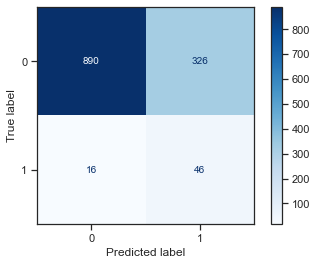

In [25]:
# Plot confusion matrix of the baseline model
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(logreg_baseline, X_test, y_test, cmap = plt.cm.Blues);

In [26]:
# Print the classification report
from sklearn.metrics import classification_report

print('Classification Report of Logistic Regression Baseline Model:')
print(classification_report(y_test, preds))

Classification Report of Logistic Regression Baseline Model:
              precision    recall  f1-score   support

           0       0.98      0.73      0.84      1216
           1       0.12      0.74      0.21        62

    accuracy                           0.73      1278
   macro avg       0.55      0.74      0.53      1278
weighted avg       0.94      0.73      0.81      1278



The logistic regression baseline model with default parameters had recall of 74%, meaning that if a person belongs to class 1 (having a stroke), there is about 74% chance that the model will correctly label this person as class 1. The number of false negatives was equal to 16. The accuracy of the model constituted 73%, meaning that the model correctly identifies if a person will have a stroke about 73% of the time.

The hyperparameters were tuned to check if the model will perform any better.

In [27]:
# Use the GridSerch to find better hyperparameters
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

logreg_tuned = LogisticRegression(random_state=42)
param_grid = {'penalty' : ['l1', 'l2', 'elasticnet'],
              'solver' : ['liblinear', 'saga']}
    
grid_search = GridSearchCV(estimator = logreg_tuned,
                           param_grid = param_grid,
                           cv = 3)
grid_search.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=3, estimator=LogisticRegression(random_state=42),
             param_grid={'penalty': ['l1', 'l2', 'elasticnet'],
                         'solver': ['liblinear', 'saga']})

In [28]:
# Print the hyperparameters
grid_search.best_params_

{'penalty': 'l2', 'solver': 'liblinear'}

In [29]:
# Build a model with mentioned hyperparameters 
logreg_tuned = LogisticRegression(random_state=42,
                                  penalty='l2',
                                  solver='liblinear')
logreg_tuned.fit(X_train_resampled, y_train_resampled)

LogisticRegression(random_state=42, solver='liblinear')

In [30]:
# Evaluate the model's performance
preds = logreg_tuned.predict(X_test)
print("Logistic Regression Tuned Model:")
print_metrics(y_test, preds)

Logistic Regression Tuned Model:
Accuracy Score: 0.7300469483568075
Precision Score: 0.1246684350132626
Recall Score: 0.7580645161290323
F1 Score: 0.21412300683371296


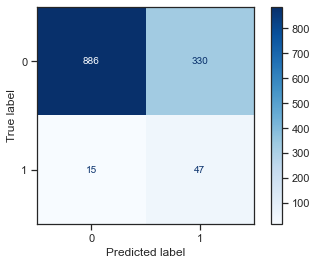

In [31]:
# Plot the confusion matrix 
plot_confusion_matrix(logreg_tuned, X_test, y_test, cmap = plt.cm.Blues);

In [32]:
# Print classification report
print('Classification Report of Logistic Regression Tuned Model:')
print(classification_report(y_test, preds))

Classification Report of Logistic Regression Tuned Model:
              precision    recall  f1-score   support

           0       0.98      0.73      0.84      1216
           1       0.12      0.76      0.21        62

    accuracy                           0.73      1278
   macro avg       0.55      0.74      0.53      1278
weighted avg       0.94      0.73      0.81      1278



The logistic regression tuned model performed a little better: the recall score got higher (76%), while the number of false negatives got a little less (15). The logistic regression tuned model was chosen for future analysis.

#### Decision Tree Models

In [33]:
# Build a baseline model 
from sklearn.tree import DecisionTreeClassifier

dt_baseline = DecisionTreeClassifier(random_state=42)
dt_baseline.fit(X_train_resampled, y_train_resampled)

DecisionTreeClassifier(random_state=42)

In [34]:
# Evaluate the model's performance
preds = dt_baseline.predict(X_test)
print("Decision Tree Baseline Model:")
print_metrics(y_test, preds)

Decision Tree Baseline Model:
Accuracy Score: 0.8442879499217527
Precision Score: 0.11731843575418995
Recall Score: 0.3387096774193548
F1 Score: 0.17427385892116182


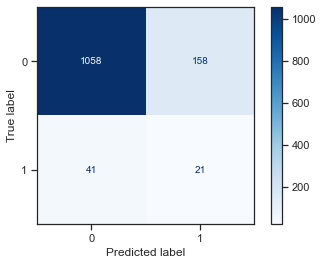

In [35]:
# Plot the confusion matrix
plot_confusion_matrix(dt_baseline, X_test, y_test, cmap = plt.cm.Blues);

In [36]:
# Print classification report
print('Classification Report of Decision Tree Baseline Model:')
print(classification_report(y_test, preds))

Classification Report of Decision Tree Baseline Model:
              precision    recall  f1-score   support

           0       0.96      0.87      0.91      1216
           1       0.12      0.34      0.17        62

    accuracy                           0.84      1278
   macro avg       0.54      0.60      0.54      1278
weighted avg       0.92      0.84      0.88      1278



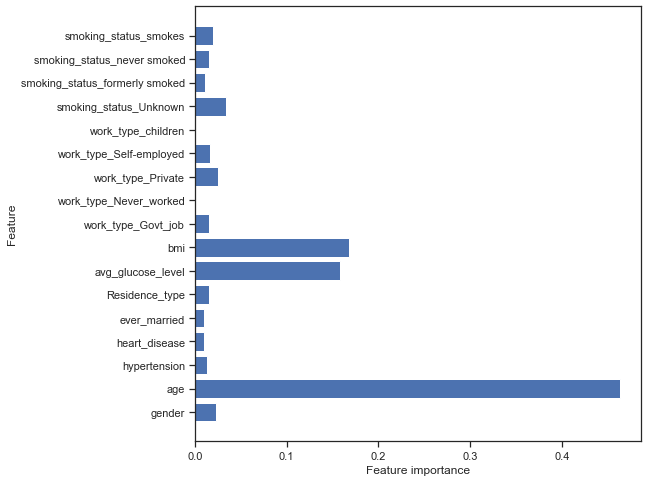

In [37]:
# Examine how important each feature ends up in the model
def plot_feature_importances(model):
    n_features = X_train_resampled.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), X_train_resampled.columns.values)
    plt.xlabel("Feature importance")
    plt.ylabel('Feature')
    
plot_feature_importances(dt_baseline)

The decision tree baseline model had a recall of 34%, which was less than the logistic regression models. The number of false negatives got higher and became equal to 41. The model used all the features except "work_type_Never_worked" and "work_type_children" with the most important being "age", "bmi" and "avg_glucose_level". The model was then optimized to check if better recall could be achieved.

In [38]:
# Write the function that calculates and returns the recall score between true and predicted valueas
def performance(y_true, y_predict):
    recall = recall_score(y_true, y_predict)
    return [recall]

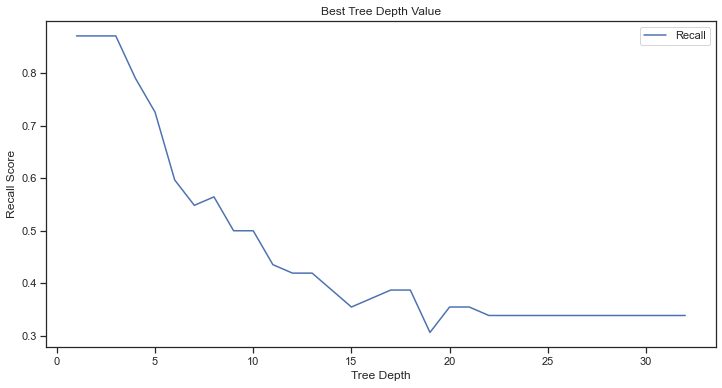

In [40]:
# Find the best tree depth using the range: 1-30
max_depths = np.linspace(1, 32, 32, endpoint=True)
recall_results = []
for max_depth in max_depths:
    dt = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    dt.fit(X_train_resampled, y_train_resampled)
    y_pred = dt.predict(X_test)
    score = performance(y_test, y_pred)
    recall_results.append(score[0])
    
plt.figure(figsize=(12,6))
plt.plot(max_depths, recall_results, label='Recall')
plt.ylabel('Recall Score')
plt.xlabel("Tree Depth")
plt.title('Best Tree Depth Value')
plt.legend()
plt.show();

According to the above graph, the best tree depth is equal to 4.

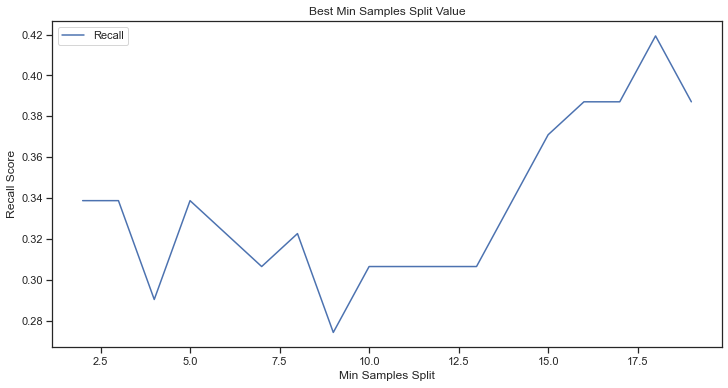

In [41]:
# Find the best min samples split
min_samples_splits = np.arange(2, 20)
recall_results = []
for min_samples_split in min_samples_splits:
    dt = DecisionTreeClassifier(
        min_samples_split=int(min_samples_split),
        random_state=42)
    dt.fit(X_train_resampled, y_train_resampled)
    y_pred = dt.predict(X_test)
    score = performance(y_test, y_pred)
    recall_results.append(score[0])
    
plt.figure(figsize=(12,6))
plt.plot(min_samples_splits, recall_results, label='Recall')
plt.ylabel('Recall Score')
plt.xlabel("Min Samples Split")
plt.title('Best Min Samples Split Value')
plt.legend()
plt.show();

According to the graph, the best value for min samples split is 18.

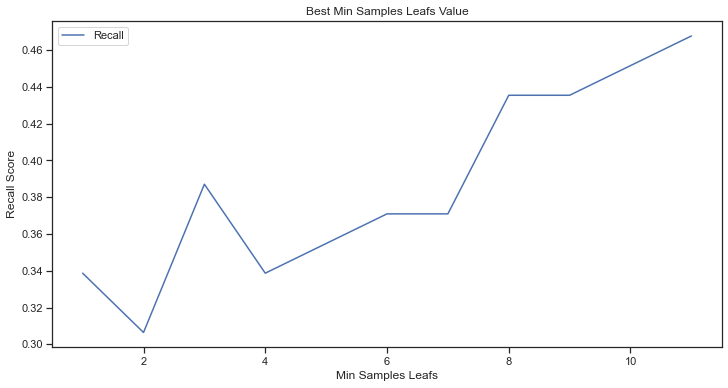

In [42]:
# Find the best min samples leafs
min_samples_leafs = np.arange(1, 12)
recall_results = []
for min_samples_leaf in min_samples_leafs:
    dt = DecisionTreeClassifier(
        min_samples_leaf=int(min_samples_leaf),
        random_state=42)
    dt.fit(X_train_resampled, y_train_resampled)
    y_pred = dt.predict(X_test)
    score = performance(y_test, y_pred)
    recall_results.append(score[0])
    
plt.figure(figsize=(12,6))
plt.plot(min_samples_leafs, recall_results, label='Recall')
plt.ylabel('Recall Score')
plt.xlabel("Min Samples Leafs")
plt.title('Best Min Samples Leafs Value')
plt.legend()
plt.show();

The best value for min samples leafs is 9.

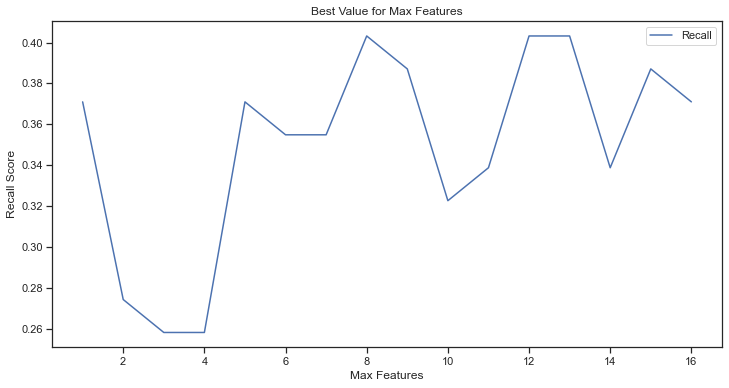

In [43]:
# Find best max features
max_features = list(range(1, X_train_resampled.shape[1]))
recall_results = []
for max_feature in max_features:
    dt = DecisionTreeClassifier(
        max_features=max_feature,
        random_state=42)
    dt.fit(X_train_resampled, y_train_resampled)
    y_pred = dt.predict(X_test)
    score = performance(y_test, y_pred)
    recall_results.append(score[0])
    
plt.figure(figsize=(12,6))
plt.plot(max_features, recall_results, label='Recall')
plt.ylabel('Recall Score')
plt.xlabel("Max Features")
plt.title('Best Value for Max Features')
plt.legend()
plt.show();

The best max feature parameter should be equal 13 to obtain the highest recall score. The optimized model was then run and evaluated.

In [44]:
# Run an optimized model with the found values and find the average cross-validated log loss
dt_tuned = DecisionTreeClassifier(
    random_state=42,
    max_depth=4,
    min_samples_split=18,
    min_samples_leaf=9,
    max_features=13)
dt_tuned.fit(X_train_resampled, y_train_resampled)

DecisionTreeClassifier(max_depth=4, max_features=13, min_samples_leaf=9,
                       min_samples_split=18, random_state=42)

In [45]:
# Check the model's performance
preds = dt_tuned.predict(X_test)
print("Decision Tree Tuned Model:")
print_metrics(y_test, preds)

Decision Tree Tuned Model:
Accuracy Score: 0.7183098591549296
Precision Score: 0.11794871794871795
Recall Score: 0.7419354838709677
F1 Score: 0.20353982300884957


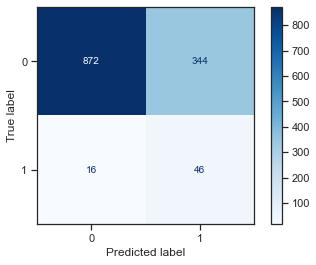

In [46]:
# Plot the confusion matrix
plot_confusion_matrix(dt_tuned, X_test, y_test, cmap = plt.cm.Blues);

In [47]:
# Print classification report
print('Classification Report of Decision Tree Tuned Model:')
print(classification_report(y_test, preds))

Classification Report of Decision Tree Tuned Model:
              precision    recall  f1-score   support

           0       0.98      0.72      0.83      1216
           1       0.12      0.74      0.20        62

    accuracy                           0.72      1278
   macro avg       0.55      0.73      0.52      1278
weighted avg       0.94      0.72      0.80      1278



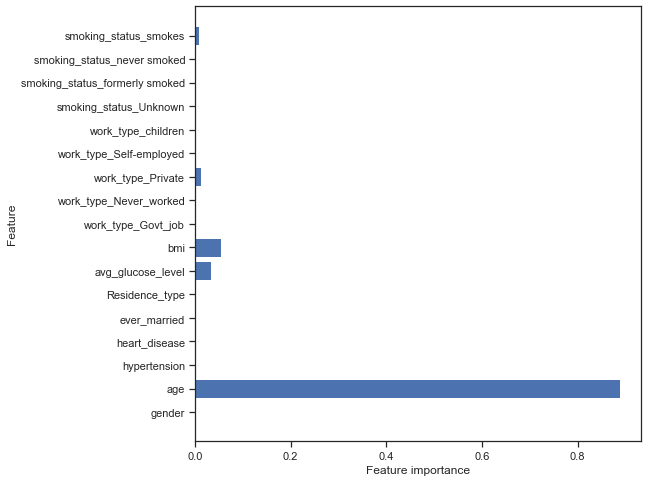

In [48]:
# Examine how important each feature is in the model
plot_feature_importances(dt_tuned)

The decision tree tuned model performed much better than the baseline model. It showed the recall of 74% with false negatives being equal to 16. The model considered "age", "work_type_Private", "bmi" and "avg_glucose_level" as the most important features. The model was chosen for future analysis.

#### Bagged Trees Models

In [49]:
# Build a baseline model with Bagging and find the average cross-validated log loss
# Set the n_estimators parameter to 100
from sklearn.ensemble import BaggingClassifier

bagged_tree_baseline = BaggingClassifier(DecisionTreeClassifier(random_state=42), n_estimators=100)
bagged_tree_baseline.fit(X_train_resampled, y_train_resampled)

BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=42),
                  n_estimators=100)

In [50]:
# Evaluate the performance of the model
preds = bagged_tree_baseline.predict(X_test)
print("Bagged Tree Baseline Model:")
print_metrics(y_test, preds)

Bagged Tree Baseline Model:
Accuracy Score: 0.8591549295774648
Precision Score: 0.13125
Recall Score: 0.3387096774193548
F1 Score: 0.1891891891891892


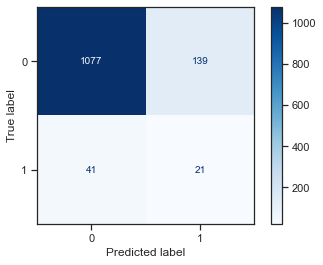

In [51]:
# Plot the confusion matrix
plot_confusion_matrix(bagged_tree_baseline, X_test, y_test, cmap = plt.cm.Blues);

In [52]:
# Print classification report
print('Classification Report of Bagged Tree Baseline Model:')
print(classification_report(y_test, preds))

Classification Report of Bagged Tree Baseline Model:
              precision    recall  f1-score   support

           0       0.96      0.89      0.92      1216
           1       0.13      0.34      0.19        62

    accuracy                           0.86      1278
   macro avg       0.55      0.61      0.56      1278
weighted avg       0.92      0.86      0.89      1278



The bagged tree baseline model didn't perform well enough. The recall score was equal to 34%, while the number of false negatives became 41. The model got to be tuned to perform better.

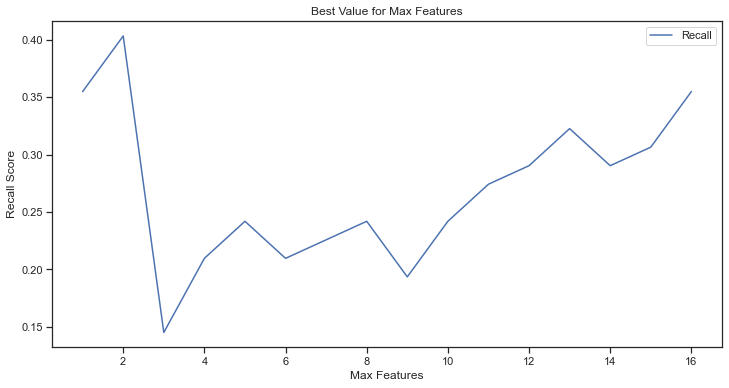

In [53]:
# Find the best value for max features
max_features = list(range(1, X_train_resampled.shape[1]))
recall_results = []
for max_feature in max_features:
    bagged = BaggingClassifier(DecisionTreeClassifier(random_state=42),
                                    n_estimators=100,
                                    max_features=max_feature)
    bagged.fit(X_train_resampled, y_train_resampled)
    y_pred = bagged.predict(X_test)
    score = performance(y_test, y_pred)
    recall_results.append(score[0])
    
plt.figure(figsize=(12,6))
plt.plot(max_features, recall_results, label='Recall')
plt.ylabel('Recall Score')
plt.xlabel("Max Features")
plt.title('Best Value for Max Features')
plt.legend()
plt.show();

According to the above graph, the best max features should be equal to 2 in order to get a higher recall value.

In [54]:
# Run the model with tuned hyperparameter
bagged_tree_tuned = BaggingClassifier(DecisionTreeClassifier(random_state=42), n_estimators=100, max_features=2)
bagged_tree_tuned.fit(X_train_resampled, y_train_resampled)

BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=42),
                  max_features=2, n_estimators=100)

In [55]:
# Evaluate the performance
preds = bagged_tree_tuned.predict(X_test)
print("Bagged Tree Tuned Model:")
print_metrics(y_test, preds)

Bagged Tree Tuned Model:
Accuracy Score: 0.8802816901408451
Precision Score: 0.15789473684210525
Recall Score: 0.3387096774193548
F1 Score: 0.21538461538461537


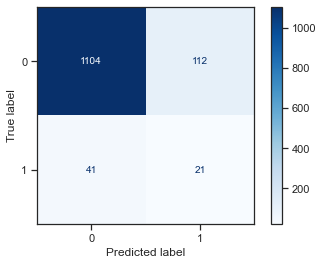

In [56]:
# Plot the confusion matrix
plot_confusion_matrix(bagged_tree_tuned, X_test, y_test, cmap = plt.cm.Blues);

In [57]:
# Print classification report
print('Classification Report of Bagged Tree Tuned Model:')
print(classification_report(y_test, preds))

Classification Report of Bagged Tree Tuned Model:
              precision    recall  f1-score   support

           0       0.96      0.91      0.94      1216
           1       0.16      0.34      0.22        62

    accuracy                           0.88      1278
   macro avg       0.56      0.62      0.58      1278
weighted avg       0.93      0.88      0.90      1278



The bagged tree tuned model didn't perform differently: the recall score stayed the same 34%, while the number of false negatives remained equal to 41. But because the accuracy score of the bagged tree tuned model was higher, the model was chosen for further analysis.

#### Random Forest Models

In [58]:
# Build a baseline model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss

forest_baseline = RandomForestClassifier(random_state=42)
forest_baseline.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(random_state=42)

In [59]:
# Evaluate the model
preds = forest_baseline.predict(X_test)
print("Random Forest Baseline Model:")
print_metrics(y_test, preds)

Random Forest Baseline Model:
Accuracy Score: 0.8693270735524257
Precision Score: 0.13793103448275862
Recall Score: 0.3225806451612903
F1 Score: 0.1932367149758454


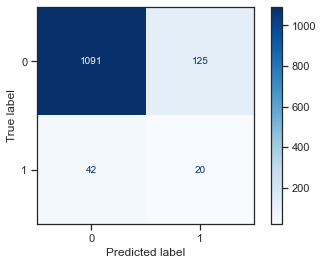

In [60]:
# Plot the confusion matrix
plot_confusion_matrix(forest_baseline, X_test, y_test, cmap = plt.cm.Blues);

In [61]:
# Print classification report
print('Classification Report of Random Forest Baseline Model:')
print(classification_report(y_test, preds))

Classification Report of Random Forest Baseline Model:
              precision    recall  f1-score   support

           0       0.96      0.90      0.93      1216
           1       0.14      0.32      0.19        62

    accuracy                           0.87      1278
   macro avg       0.55      0.61      0.56      1278
weighted avg       0.92      0.87      0.89      1278



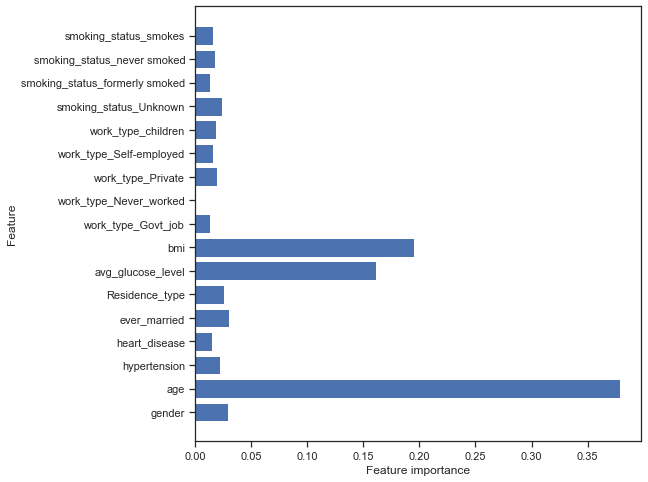

In [62]:
# Find out the importance of the features in the baseline model
plot_feature_importances(forest_baseline)

The random forest baseline model didn't perform well enough: it had a low recall score (32%) with the high number of false negatives (42). The model gave the strongest importance to "age", "avg_glucose_level" and "bmi" columns. The model was then tuned to find if it could perform any better.

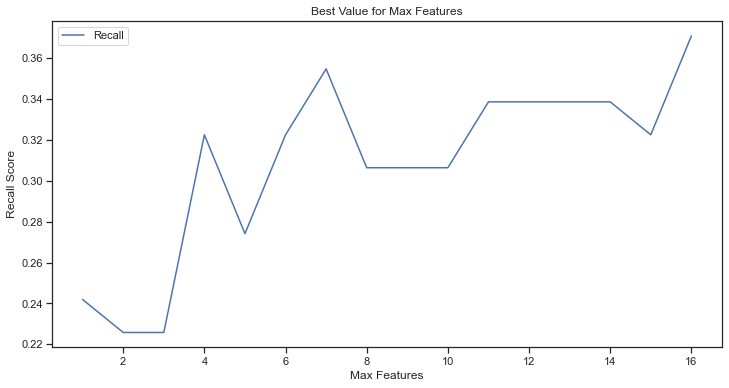

In [63]:
# Find the best value for max features
max_features = list(range(1, X_train_resampled.shape[1]))
recall_results = []
for max_feature in max_features:
    forest = RandomForestClassifier(random_state=42,
                                    max_features=max_feature)
    forest.fit(X_train_resampled, y_train_resampled)
    y_pred = forest.predict(X_test)
    score = performance(y_test, y_pred)
    recall_results.append(score[0])
    
plt.figure(figsize=(12,6))
plt.plot(max_features, recall_results, label='Recall')
plt.ylabel('Recall Score')
plt.xlabel("Max Features")
plt.title('Best Value for Max Features')
plt.legend()
plt.show();

The best value of max features should be equal to 7 in order to get the higher recall value. 

In [64]:
# Run the optimized model
forest_tuned = RandomForestClassifier(random_state=42, max_features=7)
forest_tuned.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(max_features=7, random_state=42)

In [65]:
# Evaluate the optimized model
preds = forest_tuned.predict(X_test)
print("Random Forest Tuned Model:")
print_metrics(y_test, preds)

Random Forest Tuned Model:
Accuracy Score: 0.8755868544600939
Precision Score: 0.15602836879432624
Recall Score: 0.3548387096774194
F1 Score: 0.21674876847290642


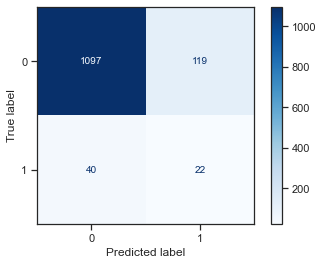

In [66]:
# Plot the confusion matrix
plot_confusion_matrix(forest_tuned, X_test, y_test, cmap = plt.cm.Blues);

In [67]:
# Print classification report
print('Classification Report of Random Forest Tuned Model:')
print(classification_report(y_test, preds))

Classification Report of Random Forest Tuned Model:
              precision    recall  f1-score   support

           0       0.96      0.90      0.93      1216
           1       0.16      0.35      0.22        62

    accuracy                           0.88      1278
   macro avg       0.56      0.63      0.57      1278
weighted avg       0.93      0.88      0.90      1278



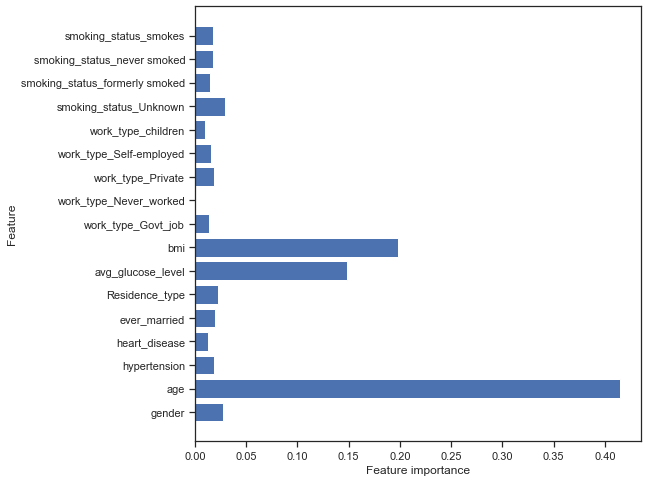

In [68]:
# Check the importance of features in the optimized model
plot_feature_importances(forest_tuned)

The recall score got a little better (35%), and the number of false negatives got a little bit lower (40). The model considered "age", "bmi", and "avg_glucose_level" as the most important features and didn't take into consideration "work_type_Never_worked". The random forest tuned model was chosen for further analysis.

#### AdaBoost Models

In [69]:
# Build a baseline model
from sklearn.ensemble import AdaBoostClassifier

adaboost_baseline = AdaBoostClassifier(random_state=42)
adaboost_baseline.fit(X_train_resampled, y_train_resampled)

AdaBoostClassifier(random_state=42)

In [70]:
# Evaluate the model
preds = adaboost_baseline.predict(X_test)
print("AdaBoost Baseline Model:")
print_metrics(y_test, preds)

AdaBoost Baseline Model:
Accuracy Score: 0.7464788732394366
Precision Score: 0.11242603550295859
Recall Score: 0.6129032258064516
F1 Score: 0.19


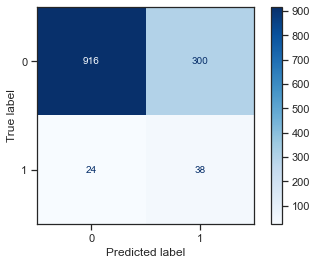

In [71]:
# Plot the confusion matrix
plot_confusion_matrix(adaboost_baseline, X_test, y_test, cmap = plt.cm.Blues);

In [72]:
# Print classification report
print('Classification Report of Adaboost Baseline Model:')
print(classification_report(y_test, preds))

Classification Report of Adaboost Baseline Model:
              precision    recall  f1-score   support

           0       0.97      0.75      0.85      1216
           1       0.11      0.61      0.19        62

    accuracy                           0.75      1278
   macro avg       0.54      0.68      0.52      1278
weighted avg       0.93      0.75      0.82      1278



The adaboost baseline model had a recall of 61% and 24 false negative results. The model was optimized to check for better performance.

In [73]:
# Use the Grid Search to fins the best learning rate
adaboost_tuned = AdaBoostClassifier(random_state=42)
param_grid = {'learning_rate' : [0.1, 0.2]}
    
grid_search = GridSearchCV(estimator = adaboost_tuned,
                           param_grid = param_grid,
                           cv = 3)
grid_search.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=3, estimator=AdaBoostClassifier(random_state=42),
             param_grid={'learning_rate': [0.1, 0.2]})

In [74]:
# Print the best parameters
grid_search.best_params_

{'learning_rate': 0.2}

In [75]:
# Run the optimized model to find the average cross-validated log loss
adaboost_tuned = AdaBoostClassifier(
    random_state=42,
    learning_rate=0.2)
adaboost_tuned.fit(X_train_resampled, y_train_resampled)

AdaBoostClassifier(learning_rate=0.2, random_state=42)

In [76]:
# Evaluate the model
preds = adaboost_tuned.predict(X_test)
print("AdaBoost Tuned Model:")
print_metrics(y_test, preds)

AdaBoost Tuned Model:
Accuracy Score: 0.6643192488262911
Precision Score: 0.11368421052631579
Recall Score: 0.8709677419354839
F1 Score: 0.2011173184357542


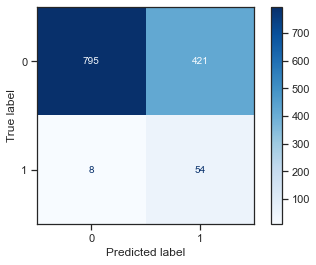

In [77]:
# Plot the confusion matrix
plot_confusion_matrix(adaboost_tuned, X_test, y_test, cmap = plt.cm.Blues);

In [78]:
# Print classification report
print('Classification Report of Adaboost Tuned Model:')
print(classification_report(y_test, preds))

Classification Report of Adaboost Tuned Model:
              precision    recall  f1-score   support

           0       0.99      0.65      0.79      1216
           1       0.11      0.87      0.20        62

    accuracy                           0.66      1278
   macro avg       0.55      0.76      0.49      1278
weighted avg       0.95      0.66      0.76      1278



The adaboost tuned model performed much better: recall score became equal to 87%, while the number of false negatives dropped to 8. The adaboost tuned model was chosen for further analysis.

#### Gradient Boosting Models

In [79]:
# Build a baseline model and find the average of the cross-validated log loss
from sklearn.ensemble import GradientBoostingClassifier

gbt_baseline = GradientBoostingClassifier(random_state=42)
gbt_baseline.fit(X_train_resampled, y_train_resampled)

GradientBoostingClassifier(random_state=42)

In [80]:
# Evaluate the model
preds = gbt_baseline.predict(X_test)
print("Gradient Boosting Baseline Model:")
print_metrics(y_test, preds)

Gradient Boosting Baseline Model:
Accuracy Score: 0.8043818466353677
Precision Score: 0.124
Recall Score: 0.5
F1 Score: 0.1987179487179487


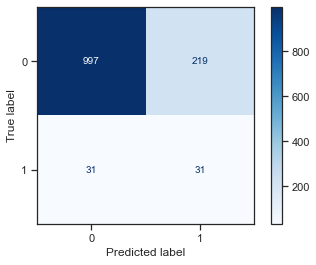

In [81]:
# Plot the confusion matrix
plot_confusion_matrix(gbt_baseline, X_test, y_test, cmap = plt.cm.Blues);

In [82]:
# Print classification report
print('Classification Report of Gradient Boosting Baseline Model:')
print(classification_report(y_test, preds))

Classification Report of Gradient Boosting Baseline Model:
              precision    recall  f1-score   support

           0       0.97      0.82      0.89      1216
           1       0.12      0.50      0.20        62

    accuracy                           0.80      1278
   macro avg       0.55      0.66      0.54      1278
weighted avg       0.93      0.80      0.86      1278



The performance of the gradient boosting baseline model was as follows: recall score constituted 50%, while the number of false negatives was equal to 31. The optimized model was then build and eveluated.

In [83]:
# Use the grid search to find the best learning rate
gbt = GradientBoostingClassifier(random_state=42)
param_grid = {'learning_rate' : [0.5, 0.7, 1.0]}
    
grid_search = GridSearchCV(estimator = gbt,
                           param_grid = param_grid,
                           cv = 3)
grid_search.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=42),
             param_grid={'learning_rate': [0.5, 0.7, 1.0]})

In [84]:
# Print the best parameter
grid_search.best_params_

{'learning_rate': 0.7}

In [85]:
# Run the optimized model
gbt_tuned = GradientBoostingClassifier(
    random_state=42,
    learning_rate=0.7)
gbt_tuned.fit(X_train_resampled, y_train_resampled)

GradientBoostingClassifier(learning_rate=0.7, random_state=42)

In [86]:
# Evaluate the model
preds = gbt_tuned.predict(X_test)
print("Gradient Boosting Tuned Model:")
print_metrics(y_test, preds)

Gradient Boosting Tuned Model:
Accuracy Score: 0.8904538341158059
Precision Score: 0.14545454545454545
Recall Score: 0.25806451612903225
F1 Score: 0.18604651162790697


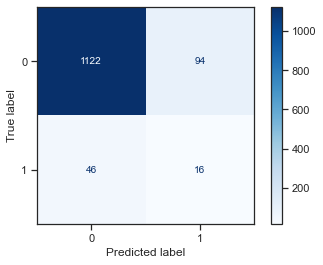

In [87]:
# Plot the confusion matrix
plot_confusion_matrix(gbt_tuned, X_test, y_test, cmap = plt.cm.Blues);

In [88]:
# Print classification report
print('Classification Report of Gradient Boosting Tuned Model:')
print(classification_report(y_test, preds))

Classification Report of Gradient Boosting Tuned Model:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94      1216
           1       0.15      0.26      0.19        62

    accuracy                           0.89      1278
   macro avg       0.55      0.59      0.56      1278
weighted avg       0.92      0.89      0.90      1278



The gradient boosting tuned model performed a little worse than the baseline model: the recall score dropped to 26%, while the false negatives increased to 46. The baseline model was chosen.

#### XGBoost Models

In [89]:
# Build and run a baseline model
from xgboost import XGBClassifier

xgb_baseline = XGBClassifier(random_state=42)
xgb_baseline.fit(X_train_resampled, y_train_resampled)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [90]:
# Evaluate the model
preds = xgb_baseline.predict(X_test)
print("XGBoost Baseline Model:")
print_metrics(y_test, preds)

XGBoost Baseline Model:
Accuracy Score: 0.9061032863849765
Precision Score: 0.14634146341463414
Recall Score: 0.1935483870967742
F1 Score: 0.16666666666666666


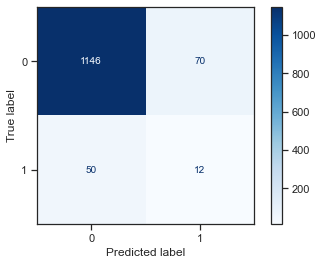

In [91]:
# Plot the confusion matrix
plot_confusion_matrix(xgb_baseline, X_test, y_test, cmap = plt.cm.Blues);

In [92]:
# Print classification report
print('Classification Report of XGBoost Baseline Model:')
print(classification_report(y_test, preds))

Classification Report of XGBoost Baseline Model:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1216
           1       0.15      0.19      0.17        62

    accuracy                           0.91      1278
   macro avg       0.55      0.57      0.56      1278
weighted avg       0.92      0.91      0.91      1278



The XGBoost baseline model was not great: the recall got equal to only 19%. The model was optimized to check for higher performance.

In [93]:
# Use the grid search to find the best hyperparameters
xgb = XGBClassifier(random_state=42)
param_grid = {'learning_rate' : [0.1, 0.2],
              'max_depth' : [6],
              'min_child_weight' : [1, 2],
              'subsample' : [0.5, 0.7],
              'n_estimators' : [100]}
    
grid_search = GridSearchCV(estimator = xgb,
                           param_grid = param_grid,
                           cv = 3)
grid_search.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=42,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, v

In [94]:
# Print the best hyperparameters
grid_search.best_params_

{'learning_rate': 0.2,
 'max_depth': 6,
 'min_child_weight': 1,
 'n_estimators': 100,
 'subsample': 0.7}

In [95]:
# Run the optimized model
xgb_tuned = XGBClassifier(random_state=42,
                          learning_rate=0.2,
                          max_depth=6,
                          min_child_weight=1,
                          n_estimators=100,
                          subsample=0.7)
xgb_tuned.fit(X_train_resampled, y_train_resampled)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.7,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [96]:
# Evaluate the model
preds = xgb_tuned.predict(X_test)
print("XGBoost Tuned Model:")
print_metrics(y_test, preds)

XGBoost Tuned Model:
Accuracy Score: 0.8896713615023474
Precision Score: 0.13761467889908258
Recall Score: 0.24193548387096775
F1 Score: 0.17543859649122806


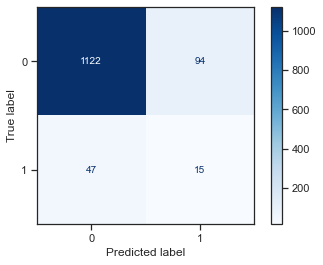

In [97]:
# Plot the confusion matrix
plot_confusion_matrix(xgb_tuned, X_test, y_test, cmap = plt.cm.Blues);

In [98]:
# Print classification report
print('Classification Report of XGBoost Tuned Model:')
print(classification_report(y_test, preds))

Classification Report of XGBoost Tuned Model:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94      1216
           1       0.14      0.24      0.18        62

    accuracy                           0.89      1278
   macro avg       0.55      0.58      0.56      1278
weighted avg       0.92      0.89      0.90      1278



The XGBoost tuned model perfromed a little better: the recall became equal to only 24% now. The XGBoost tuned model was chosen.

#### Naive Bayes Models

In [99]:
# Build a baseline model 
from sklearn.naive_bayes import GaussianNB

naive_bayes_baseline = GaussianNB()
naive_bayes_baseline.fit(X_train_resampled, y_train_resampled)

GaussianNB()

In [100]:
# Evaluate the model
preds = naive_bayes_baseline.predict(X_test)
print("Naive Bayes Baseline Model:")
print_metrics(y_test, preds)

Naive Bayes Baseline Model:
Accuracy Score: 0.3701095461658842
Precision Score: 0.07052023121387284
Recall Score: 0.9838709677419355
F1 Score: 0.13160733549083065


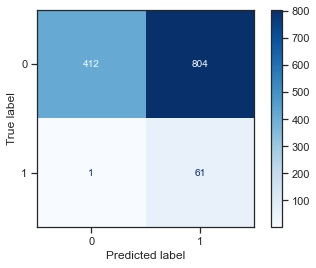

In [101]:
# Plot the confusion matrix
plot_confusion_matrix(naive_bayes_baseline, X_test, y_test, cmap = plt.cm.Blues);

In [102]:
# Print classification report
print('Classification Report of Naive Bayes Baseline Model:')
print(classification_report(y_test, preds))

Classification Report of Naive Bayes Baseline Model:
              precision    recall  f1-score   support

           0       1.00      0.34      0.51      1216
           1       0.07      0.98      0.13        62

    accuracy                           0.37      1278
   macro avg       0.53      0.66      0.32      1278
weighted avg       0.95      0.37      0.49      1278



The naive bayes baseline model perfromed better than any model before. It got recall score of 98% with false negatives being equal to only 1. The model was still optimized to see if it could perform better.

In [103]:
# Find the best value for var_smoothing
nb = GaussianNB()
param_grid = {'var_smoothing' : np.logspace(0,-9, num=100)}
    
grid_search = GridSearchCV(estimator = nb,
                           param_grid = param_grid,
                           cv = 3)
grid_search.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=3, estimator=GaussianNB(),
             param_grid={'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-02, 5.33669923e-02, 4.32876128e-02,
       3.51119173e-02, 2.84803587e-02, 2.31...
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])})

In [104]:
# Print the best parameter
grid_search.best_params_

{'var_smoothing': 0.012328467394420659}

In [105]:
# Run the optimized model
nb_tuned = GaussianNB(var_smoothing=0.0123)
nb_tuned.fit(X_train_resampled, y_train_resampled)

GaussianNB(var_smoothing=0.0123)

In [106]:
# Evaliuate the model
preds = nb_tuned.predict(X_test)
print("Naive Bayes Tuned Model:")
print_metrics(y_test, preds)

Naive Bayes Tuned Model:
Accuracy Score: 0.6791862284820032
Precision Score: 0.11674008810572688
Recall Score: 0.8548387096774194
F1 Score: 0.2054263565891473


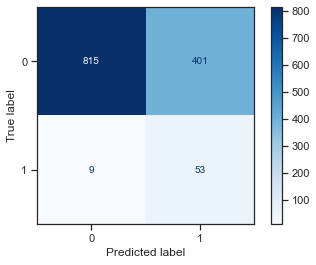

In [107]:
# Plot the confusion matrix
plot_confusion_matrix(nb_tuned, X_test, y_test, cmap = plt.cm.Blues);

In [108]:
# Print classification report
print('Classification Report of Naive Bayes Tuned Model:')
print(classification_report(y_test, preds))

Classification Report of Naive Bayes Tuned Model:
              precision    recall  f1-score   support

           0       0.99      0.67      0.80      1216
           1       0.12      0.85      0.21        62

    accuracy                           0.68      1278
   macro avg       0.55      0.76      0.50      1278
weighted avg       0.95      0.68      0.77      1278



The performance of the naive bayes tuned model got worse. The recall decreased to 85%, while the number of false negatives increased to 9. It meant that the default parameters were much better in prediction whether a person would develop a stroke. The baseline model was chosen for further analysis.

In order to build knn and svm models, one more step was needed: the data had to be normalized. That had to be done for two reasons: 

- to avoid information "leaking" from the test set into the training set;
- to avoid having a larger impact that larger scaled features have on the distance between the points in distance-based classifiers.

Normalization (AKA Standardization or Scaling) means making sure that all of the data is represented at the same scale. The most common way to do this is to convert all numerical values to z-scores.

In [109]:
# Instantiate StandardScaler and transform the variables
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

#### KNN Models

In [110]:
# Build a baseline model
from sklearn.neighbors import KNeighborsClassifier

knn_baseline = KNeighborsClassifier()
knn_baseline.fit(X_train_scaled, y_train_resampled)

KNeighborsClassifier()

In [111]:
# Evaluate the model
preds = knn_baseline.predict(X_test_scaled)
print("KNN Baseline Model:")
print_metrics(y_test, preds)

KNN Baseline Model:
Accuracy Score: 0.7824726134585289
Precision Score: 0.09090909090909091
Recall Score: 0.3870967741935484
F1 Score: 0.147239263803681


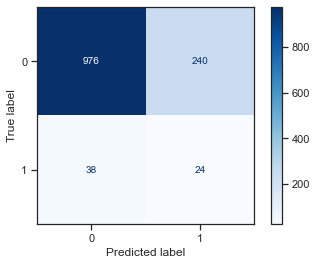

In [112]:
# Plot the confusion matrix
plot_confusion_matrix(knn_baseline, X_test_scaled, y_test, cmap = plt.cm.Blues);

In [113]:
# Print classification report
print('Classification Report of KNN Baseline Model:')
print(classification_report(y_test, preds))

Classification Report of KNN Baseline Model:
              precision    recall  f1-score   support

           0       0.96      0.80      0.88      1216
           1       0.09      0.39      0.15        62

    accuracy                           0.78      1278
   macro avg       0.53      0.59      0.51      1278
weighted avg       0.92      0.78      0.84      1278



The knn baseline model didn't perform well. The recall score was low and equal to 39%. The model was then optimized to find the best k value in order to increase the recall.

In [114]:
# Change hyperparameter to see if the model performs any better
knn_first_model = KNeighborsClassifier(n_neighbors=75)
knn_first_model.fit(X_train_scaled, y_train_resampled)
preds = knn_first_model.predict(X_test_scaled)
print_metrics(y_test, preds)

Accuracy Score: 0.6549295774647887
Precision Score: 0.08351648351648351
Recall Score: 0.6129032258064516
F1 Score: 0.14700193423597677


In [115]:
# Change hyperparameter and repeat the step above
knn_second_model = KNeighborsClassifier(n_neighbors=120)
knn_second_model.fit(X_train_scaled, y_train_resampled)
preds = knn_second_model.predict(X_test_scaled)
print_metrics(y_test, preds)

Accuracy Score: 0.6338028169014085
Precision Score: 0.08739837398373984
Recall Score: 0.6935483870967742
F1 Score: 0.1552346570397112


In [116]:
# Write the funstion that finds the best value for n_neighbors
def find_best_k(X_train, y_train, X_test, y_test, min_k=75, max_k=120):
    best_k = 0
    best_score = 0.0
    for k in range(min_k, max_k+1, 2):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        preds = knn.predict(X_test)
        recall = recall_score(y_test, preds)
        if recall > best_score:
            best_k = k
            best_score = recall
    print("Best Value for k: {}".format(best_k))
    print("Recall: {}".format(best_score))

In [117]:
# Find the best value of k for the model
find_best_k(X_train_scaled, y_train_resampled, X_test_scaled, y_test)

Best Value for k: 97
Recall: 0.7096774193548387


In [118]:
# Run the optimized model
knn_tuned = KNeighborsClassifier(n_neighbors=97)
knn_tuned.fit(X_train_scaled, y_train_resampled)

KNeighborsClassifier(n_neighbors=97)

In [119]:
# Evaluate the optimized model
preds = knn_tuned.predict(X_test_scaled)
print("KNN Tuned Model:")
print_metrics(y_test, preds)

KNN Tuned Model:
Accuracy Score: 0.6400625978090767
Precision Score: 0.09053497942386832
Recall Score: 0.7096774193548387
F1 Score: 0.16058394160583944


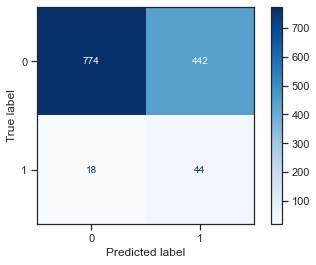

In [120]:
# Plot the confusion matrix
plot_confusion_matrix(knn_tuned, X_test_scaled, y_test, cmap = plt.cm.Blues);

In [121]:
# Print classification report
print('Classification Report of KNN Tuned Model:')
print(classification_report(y_test, preds))

Classification Report of KNN Tuned Model:
              precision    recall  f1-score   support

           0       0.98      0.64      0.77      1216
           1       0.09      0.71      0.16        62

    accuracy                           0.64      1278
   macro avg       0.53      0.67      0.47      1278
weighted avg       0.93      0.64      0.74      1278



The knn tuned model performed much better: the recall score increased to 71%, while the number of false negatives dropped to 18. The knn tuned model was chosen.

#### SVM Models

In [122]:
# Build a baseline model
from sklearn.svm import SVC

svc_baseline = SVC(random_state=42, probability=True)
svc_baseline.fit(X_train_scaled, y_train_resampled)

SVC(probability=True, random_state=42)

In [123]:
# Evaluate the model
preds = svc_baseline.predict(X_test_scaled)
print("SVM Baseline Model:")
print_metrics(y_test, preds)

SVM Baseline Model:
Accuracy Score: 0.7566510172143975
Precision Score: 0.09446254071661238
Recall Score: 0.46774193548387094
F1 Score: 0.15718157181571818


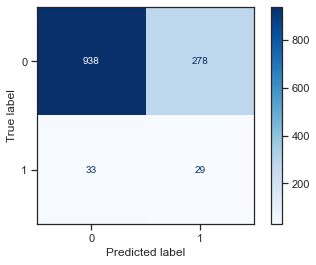

In [124]:
# Plot the confusion matrix
plot_confusion_matrix(svc_baseline, X_test_scaled, y_test, cmap = plt.cm.Blues);

In [125]:
# Print classification report
print('Classification Report of SVC Baseline Model:')
print(classification_report(y_test, preds))

Classification Report of SVC Baseline Model:
              precision    recall  f1-score   support

           0       0.97      0.77      0.86      1216
           1       0.09      0.47      0.16        62

    accuracy                           0.76      1278
   macro avg       0.53      0.62      0.51      1278
weighted avg       0.92      0.76      0.82      1278



The svc baseline model had a recall of 47% and the number of false negatives was equal to 33. The model was optimized to check for the higer recall.

In [126]:
# Find the best hyperparameters
svc = SVC(random_state=42, probability=True)
param_grid = {'C': [0.1, 1, 10],
              'gamma': [1, 0.1, 'auto']}
    
grid_search = GridSearchCV(estimator = svc,
                           param_grid = param_grid,
                           cv = 3)
grid_search.fit(X_train_scaled, y_train_resampled)

GridSearchCV(cv=3, estimator=SVC(probability=True, random_state=42),
             param_grid={'C': [0.1, 1, 10], 'gamma': [1, 0.1, 'auto']})

In [127]:
# Print the best hyperparameters
grid_search.best_params_

{'C': 10, 'gamma': 1}

In [128]:
# Run the optimized model
svc_tuned = SVC(random_state=42, probability=True, C=10, gamma=1)
svc_tuned.fit(X_train_scaled, y_train_resampled)

SVC(C=10, gamma=1, probability=True, random_state=42)

In [129]:
# Evaluate the optimized model
svc = svc_tuned.predict(X_test_scaled)
print("SVM Tuned Model:")
print_metrics(y_test, preds)

SVM Tuned Model:
Accuracy Score: 0.7566510172143975
Precision Score: 0.09446254071661238
Recall Score: 0.46774193548387094
F1 Score: 0.15718157181571818


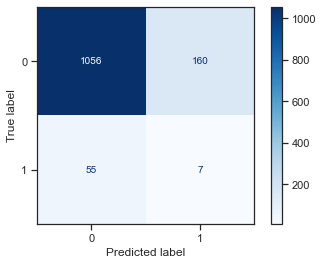

In [130]:
# Plot the confusion matrix
plot_confusion_matrix(svc_tuned, X_test_scaled, y_test, cmap = plt.cm.Blues);

In [131]:
# Print classification report
print('Classification Report of SVC Tuned Model:')
print(classification_report(y_test, preds))

Classification Report of SVC Tuned Model:
              precision    recall  f1-score   support

           0       0.97      0.77      0.86      1216
           1       0.09      0.47      0.16        62

    accuracy                           0.76      1278
   macro avg       0.53      0.62      0.51      1278
weighted avg       0.92      0.76      0.82      1278



The svc tuned model didn't perfrom any better: the recall score didn't change and was equal to 47%, but because the number of false negatives got more (55 compared to 33 in baseline model), the svc baseline model was chosen for further analysis.

***

### Model Evaluation
Based on the findings, the graph with the best recall scores was plotted. It was found out that the best recall score belonged to naive bayes baseline model. The classification report of the mentioned model was printed again.

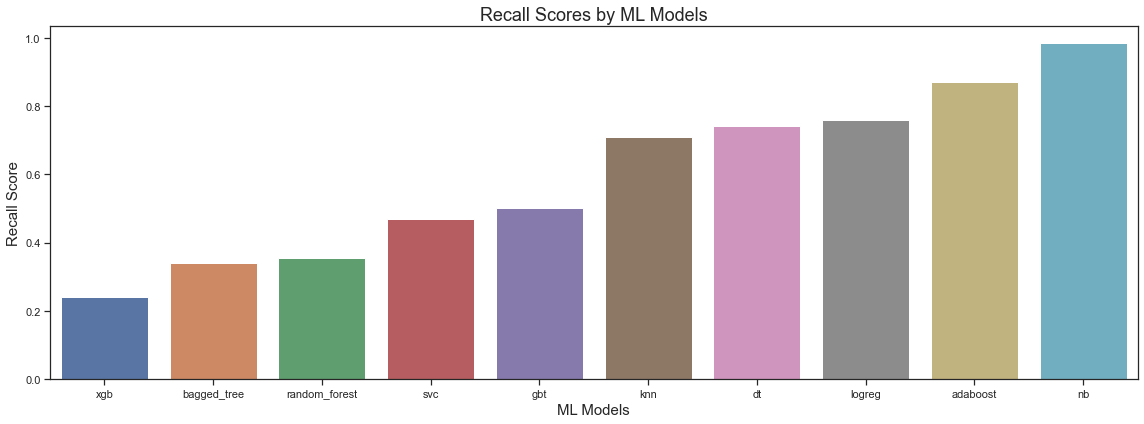

In [132]:
# Plot the graph with the best recall scores for different models
rec_logreg = recall_score(y_test, logreg_tuned.predict(X_test))
rec_dt = recall_score(y_test, dt_tuned.predict(X_test))
rec_bagged = recall_score(y_test, bagged_tree_tuned.predict(X_test))
rec_forest = recall_score(y_test, forest_tuned.predict(X_test))
rec_adaboost = recall_score(y_test, adaboost_tuned.predict(X_test))
rec_gbt = recall_score(y_test, gbt_baseline.predict(X_test))
rec_xgb = recall_score(y_test, xgb_tuned.predict(X_test))
rec_nb = recall_score(y_test, naive_bayes_baseline.predict(X_test))
rec_knn = recall_score(y_test, knn_tuned.predict(X_test_scaled))
rec_svc = recall_score(y_test, svc_baseline.predict(X_test_scaled))

recall = [rec_logreg, rec_dt, rec_bagged, rec_forest, rec_adaboost,
          rec_gbt, rec_xgb, rec_nb, rec_knn, rec_svc]
models = ['logreg', 'dt', 'bagged_tree', 'random_forest', 'adaboost',
          'gbt', 'xgb', 'nb', 'knn', 'svc']
recall_score = [round(num, 3) for num in recall]

df_recall = pd.DataFrame({'models': models, 'recall': recall_score}).sort_values(
    'recall', ascending=True)
plt.figure(figsize=(16,6))
sns.barplot(x='models', y='recall', data=df_recall)
plt.xlabel("ML Models", size=15)
plt.ylabel("Recall Score", size=15)
plt.title("Recall Scores by ML Models", size=18)
plt.tight_layout()
plt.savefig("recall.png", dpi=100)

In [133]:
# Print out the classification reports of the selected models
print('Classification Report of Naive Bayes Baseline Model:')
print(classification_report(y_test, naive_bayes_baseline.predict(X_test)))

Classification Report of Naive Bayes Baseline Model:
              precision    recall  f1-score   support

           0       1.00      0.34      0.51      1216
           1       0.07      0.98      0.13        62

    accuracy                           0.37      1278
   macro avg       0.53      0.66      0.32      1278
weighted avg       0.95      0.37      0.49      1278



Based on the report, it was determined that the model correctly identifies if a person will have a stroke about 37% of the time. Recall value of the model is 98%, meaning that if a person belongs to class 1 (having a stroke), there is about 98% chance that the model will correctly label this person as class 1. 

In [134]:
# Write the function that takes into account the default threshold
# if the model says there is >50% chance, we label it as class 1
def final_model_func(model, X):
    probs = model.predict_proba(X)[:,1]
    return [int(prob >= 0.5) for prob in probs]

# Calculate predictions and display their proportions
print('Predictions for naive bayes baseline model:')
probs_nb = pd.Series(final_model_func(naive_bayes_baseline, X_test))
probs_nb.value_counts(normalize=True)

Predictions for naive bayes baseline model:


1    0.676839
0    0.323161
dtype: float64

So we are classifying 68% of people as prone to stroke, even though fever than 5% of people are actually in that category. We do this in order to miss as few true positives as possible. This kind of model seems extreme, however, it is very useful for the stakeholders. The algorithm successfully identifies the people that are prone to stroke, so they can receive some kind of extra treatment or be monitored more often. The chosen model will allow to monitor 68% of the patients and successfully treat 98% of the ones that will develop stroke.

***

## Conclusions
The analysis of the stroke dataset resulted in the evaluation of different machine learning models that can help predict if the patients will develop stroke during their lifetime. The best model was found to be naive bayes baseline model, that had the highest recall of 98%. The chosen model correctly identifies if a person will have a stroke about 37% of the time and is able to determine 98% of the true positives (98% of the patients that will develop stroke). 

The mentioned model may seem extreme, since it classifies 68% of people as prone to stroke, while in reality fever than 5% of the patients will actually develop the illness. However, since the World Health Orgnization really cares about avoiding 'false negatives' more than avoiding 'false positives' (we have to get as fewer people as possible who, according to the model's predictions will not have a stroke, while in reality they will have), the models' performances were chosen based on the higher recall scores and lower number of false negatives. The naive bayes baseline model with recall of 98% is very useful for the stakeholder, since it successfully identifies the people that are prone to stroke. As a result these patients can receive some kind of extra treatment or be monitored more often.

Although, the model suggests the stakeholder to closely monitor the majority of the patients (68%) in order to successfully treat 98% of the ones that will develop stroke, it kills two birds with one stone:

- the model manages to decrease the death and disability rates caused by stroke;
- it promotes healthy lifestyle among the population (when people find out that they are prone to stroke, they start eating healthy, doing sports, monitoring blood pressure, etc.)

Thus, the naive bayes baseline model advices the World Health Organization and doctors to pay detailed attention to people who are over 45 years old, have hypertension and/or heart disease, high glucose level, who are married, self-employed and either smoke or formerly smoked, as their chances to develop stroke further in life are very high. 

We recommend to the World Health Organization to utilize the above described model only if there is a special kind of treatment or particular monitoring practices of blood, urine or other specimens developed only for those people who are prone to get stroke. If the stakeholder decides to change the direction of the research and, for example, to simply identifies what percentage of people will have a stroke in the future for the statistical purposes, the model has to be changed. The naive bayes model's accuracy is only 37%, which is fine only for this particular exercise. If the goal of the research changes, the model with a higher accuracy score should be chosen.

Also, to get more precise and accurate results for the prediciton of stoke occurences, more information may be needed. Thus, family history, alcohol consumption, kind of diet, the presence of diabetes, frequency of exercises, etc. by the patients are recommended to be included into the dataset.